In [15]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import math

from datetime import datetime
from scipy import stats

from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.base import BaseEstimator, TransformerMixin
from mlxtend.feature_selection import ColumnSelector
from sklearn.preprocessing import OneHotEncoder,MinMaxScaler, Normalizer
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA

### 商户特征的提取

在模型的训练中，不再使用Merchant_id，因为Merchant_id不带有任何信息，我们需要从各种信息中获取信息来刻画一个Merchant_id

+ 商家优惠券被领取次数
+ 商家优惠券被领取后核销次数
+ 商家优惠券被领取后核销率
+ 商家优惠券核销的平均/最小/最大消费折率
+ 核销商家优惠券的不同用户数量，及其占领取不同的用户比重
+ 商家优惠券平均每个用户核销多少张
+ 商家被核销过的不同优惠券数量
+ 商家被核销过的不同优惠券数量占所有领取过的不同优惠券数量的比重
+ 商家平均每种优惠券核销多少张
+ 商家被核销优惠券中的平均/最小/最大用户-商家距离

以下不参与

+ 商家被核销优惠券的平均时间率

In [16]:
base_features_df = pd.read_csv('../features/lcm_base_features.csv')

In [17]:
base_features_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1053282 entries, 0 to 1053281
Data columns (total 14 columns):
User_id              1053282 non-null int64
Merchant_id          1053282 non-null float64
Coupon_id            1053282 non-null float64
Distance             1053282 non-null float64
Date_received        1053282 non-null float64
Is_in_day_consume    1053282 non-null float64
Discount             1053282 non-null float64
Base_consume         1053282 non-null float64
Discount_money       1053282 non-null float64
Day_in_month         1053282 non-null float64
Day_in_week          1053282 non-null float64
Coupon_type          1053282 non-null float64
Offline_consume      1053282 non-null float64
Duration             1053282 non-null float64
dtypes: float64(13), int64(1)
memory usage: 112.5 MB


In [18]:
df = base_features_df.copy()

In [19]:
def join(df, col, series, key):
    return multi_join(df, col, series, [key])

def multi_join(df, col, series, keys):
    t = series.to_frame()
    t.columns = [col]
    
    return pd.merge(df, t, on=keys, how='left')

In [20]:
def receive_count(df, target, groupby, is_dup=True):
    if is_dup:
        return df[df['Date_received']>0][target].drop_duplicates().groupby(groupby).size()
    else:
        return df[df['Date_received']>0][target].groupby(groupby).size()

def cousume_count(df, target, groupby, is_dup=True):
    if is_dup:
        return df[df['Offline_consume']>0][target].drop_duplicates().groupby(groupby).size()
    else:
        return df[df['Offline_consume']>0][target].groupby(groupby).size()

def used_count(df, target, groupby, is_dup=True):
    if is_dup:
        return df[df['Is_in_day_consume']>0][target].drop_duplicates().groupby(groupby).size()
    else:
        return df[df['Is_in_day_consume']>0][target].groupby(groupby).size()

def cal_user_used_coupon_rate(row):
    return row.User_used_count/row.User_receive_count

def cal_user_not_used_conpon_count(row):
    return row.User_receive_count - row.User_used_count

def extract_info(df, target, type, groupby, column_name, is_dup=True):
    factory = {
        'receive_type': receive_count,
        'used_type': used_count
    }
    
    target_df = df[groupby].drop_duplicates()
    series = factory[type](df, target, groupby, is_dup)
    
    tdf = multi_join(target_df, column_name, series, groupby)
    tdf = tdf.fillna(0)
    
    mean = tdf[column_name].mean()
    tdf[column_name+'_occ'] = tdf[column_name] / mean
    return tdf[groupby + [column_name, column_name+'_occ']]

In [21]:
class GroupbyExtractor(TransformerMixin):
    def __init__(self, fn, target, type, groupby, column_name):
        self.fn = fn
        self.target = target
        self.type = type
        self.groupby = groupby
        self.column_name = column_name
    
    def fit(self, *args, **kwargs):
        return self

    def transform(self, X, **transform_params):
        return self.fn(X, self.target, self.type, self.groupby, self.column_name)

In [22]:
keys = ['Merchant_id']
merchant_features_df = df[['Merchant_id']].drop_duplicates()

merchant_features_df = pd.merge(merchant_features_df, extract_info(df, ['Merchant_id'], 'receive_type', ['Merchant_id'], 'Merchant_coupon_receive_count', False), on=keys, how='left')
merchant_features_df = pd.merge(merchant_features_df, extract_info(df, ['Merchant_id'], 'used_type', ['Merchant_id'], 'Merchant_coupon_used_count', False), on=keys, how='left')
merchant_features_df = pd.merge(merchant_features_df, extract_info(df, ['Merchant_id', 'User_id'], 'receive_type', ['Merchant_id'], 'Merchant_user_receive_count'), on=keys, how='left')
merchant_features_df = pd.merge(merchant_features_df, extract_info(df, ['Merchant_id', 'User_id'], 'used_type', ['Merchant_id'], 'Merchant_user_used_count'), on=keys, how='left')
merchant_features_df = pd.merge(merchant_features_df, extract_info(df, ['Merchant_id', 'Coupon_id'], 'receive_type', ['Merchant_id'], 'Merchant_receive_different_coupon_count'), on=keys, how='left')
merchant_features_df = pd.merge(merchant_features_df, extract_info(df, ['Merchant_id', 'Coupon_id'], 'used_type', ['Merchant_id'], 'Merchant_used_different_coupon_count'), on=keys, how='left')

for i in range(0, 2, 1):
    
    merchant_features_df = pd.merge(
        merchant_features_df, 
        extract_info(
            df[df['Coupon_type'] == i], 
            ['Merchant_id', 'Coupon_type'], 
            'receive_type', 
            ['Merchant_id'], 
            'Merchant_receive_coupon_type_%s_count' % (i),
            False
        ), 
        on=keys, how='left'
    )
    
    merchant_features_df = pd.merge(
        merchant_features_df, 
        extract_info(
            df[df['Coupon_type'] == i], 
            ['Merchant_id', 'Coupon_type'], 
            'used_type', 
            ['Merchant_id'], 
            'Merchant_used_coupon_type_%s_count' % (i),
            False
        ), on=keys, how='left')
    
    merchant_features_df['Merchant_used_coupon_type_%s_rate' % (i)] = merchant_features_df['Merchant_used_coupon_type_%s_count' % (i)] / merchant_features_df['Merchant_coupon_used_count']

for i in range(0, 11, 1):
    
    merchant_features_df = pd.merge(
        merchant_features_df, 
        extract_info(
            df[df['Distance'] == i], 
            ['Merchant_id', 'Distance'], 
            'receive_type', 
            ['Merchant_id'], 
            'Merchant_receive_distance_%s_count' % (i),
            False
        ), 
        on=keys, how='left'
    )
    
    merchant_features_df = pd.merge(
        merchant_features_df, 
        extract_info(
            df[df['Distance'] == i], 
            ['Merchant_id', 'Distance'], 
            'used_type', 
            ['Merchant_id'], 
            'Merchant_used_distance_%s_count' % (i),
            False
        ), on=keys, how='left')
    
    merchant_features_df['Merchant_used_distance_%s_rate' % (i)] = merchant_features_df['Merchant_used_distance_%s_count' % (i)] / merchant_features_df['Merchant_coupon_used_count']

merchant_features_df['Merchant_coupon_used_rate'] = merchant_features_df['Merchant_coupon_used_count'] / merchant_features_df['Merchant_coupon_receive_count']

user_count = df['User_id'].unique().size
merchant_features_df['Merchant_user_receive_rate'] = merchant_features_df['Merchant_user_receive_count'] / user_count
merchant_features_df['Merchant_user_used_rate'] = merchant_features_df['Merchant_user_used_count'] / user_count

coupon_count = df['Coupon_id'].unique().size
merchant_features_df['Merchant_receive_different_coupon_rate'] = merchant_features_df['Merchant_receive_different_coupon_count'] / coupon_count
merchant_features_df['Merchant_used_different_coupon_rate'] = merchant_features_df['Merchant_used_different_coupon_count'] / coupon_count

merchant_features_df = merchant_features_df.fillna(0)

merchant_features_df['Merchant_coupon_used_rate_occ'] = merchant_features_df['Merchant_coupon_used_rate'] / merchant_features_df['Merchant_coupon_used_rate'].mean()

In [23]:
t = base_features_df[['Merchant_id', 'Discount']].groupby('Merchant_id').agg(['mean', 'max', 'min'])
t.columns = ["_Merchant_".join(x) for x in t.columns.ravel()]
merchant_features_df = pd.merge(merchant_features_df, t, on=keys, how='left')

In [24]:
t = base_features_df[['Merchant_id', 'Distance']].groupby('Merchant_id').agg(['mean', 'max', 'min'])
t.columns = ["_Merchant_".join(x) for x in t.columns.ravel()]
merchant_features_df = pd.merge(merchant_features_df, t, on=keys, how='left')

In [25]:
merchant_features_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5599 entries, 0 to 5598
Data columns (total 90 columns):
Merchant_id                                    5599 non-null float64
Merchant_coupon_receive_count                  5599 non-null int64
Merchant_coupon_receive_count_occ              5599 non-null float64
Merchant_coupon_used_count                     5599 non-null float64
Merchant_coupon_used_count_occ                 5599 non-null float64
Merchant_user_receive_count                    5599 non-null int64
Merchant_user_receive_count_occ                5599 non-null float64
Merchant_user_used_count                       5599 non-null float64
Merchant_user_used_count_occ                   5599 non-null float64
Merchant_receive_different_coupon_count        5599 non-null int64
Merchant_receive_different_coupon_count_occ    5599 non-null float64
Merchant_used_different_coupon_count           5599 non-null float64
Merchant_used_different_coupon_count_occ       5599 non-null float64
Me

In [26]:
merchant_features_df.columns.values

array(['Merchant_id', 'Merchant_coupon_receive_count',
       'Merchant_coupon_receive_count_occ', 'Merchant_coupon_used_count',
       'Merchant_coupon_used_count_occ', 'Merchant_user_receive_count',
       'Merchant_user_receive_count_occ', 'Merchant_user_used_count',
       'Merchant_user_used_count_occ',
       'Merchant_receive_different_coupon_count',
       'Merchant_receive_different_coupon_count_occ',
       'Merchant_used_different_coupon_count',
       'Merchant_used_different_coupon_count_occ',
       'Merchant_receive_coupon_type_0_count',
       'Merchant_receive_coupon_type_0_count_occ',
       'Merchant_used_coupon_type_0_count',
       'Merchant_used_coupon_type_0_count_occ',
       'Merchant_used_coupon_type_0_rate',
       'Merchant_receive_coupon_type_1_count',
       'Merchant_receive_coupon_type_1_count_occ',
       'Merchant_used_coupon_type_1_count',
       'Merchant_used_coupon_type_1_count_occ',
       'Merchant_used_coupon_type_1_rate',
       'Merchant_recei

In [27]:
merchant_features_df.head(20)

,Merchant_id,Merchant_coupon_receive_count,Merchant_coupon_receive_count_occ,Merchant_coupon_used_count,Merchant_coupon_used_count_occ,Merchant_user_receive_count,Merchant_user_receive_count_occ,Merchant_user_used_count,Merchant_user_used_count_occ,Merchant_receive_different_coupon_count,...,Merchant_user_used_rate,Merchant_receive_different_coupon_rate,Merchant_used_different_coupon_rate,Merchant_coupon_used_rate_occ,Discount_Merchant_mean,Discount_Merchant_max,Discount_Merchant_min,Distance_Merchant_mean,Distance_Merchant_max,Distance_Merchant_min
0,4663.0,15191,80.751792,56.0,4.869074,14919,97.529386,53.0,6.895801,6,...,0.000104,0.000616,0.000616,0.023138,0.866667,0.866667,0.866667,3.116911,10.0,-1.0
1,2632.0,43,0.228578,1.0,0.086948,15,0.098059,1.0,0.130109,2,...,0.000002,0.000205,0.000103,0.145968,0.950000,0.950000,0.950000,0.906977,10.0,-1.0
2,3381.0,122834,652.956726,1553.0,135.029847,106971,699.297270,1429.0,185.926405,8,...,0.002798,0.000822,0.000822,0.079356,0.866312,0.900000,0.500000,2.806234,10.0,-1.0
3,450.0,63042,335.116482,1010.0,87.817222,52633,344.075620,785.0,102.135919,19,...,0.001537,0.001951,0.001848,0.100558,0.832125,0.990000,0.666667,3.766949,10.0,-1.0
4,6459.0,16,0.085052,0.0,0.000000,15,0.098059,0.0,0.000000,1,...,0.000000,0.000103,0.000000,0.000000,0.950000,0.950000,0.950000,0.500000,4.0,-1.0
5,6901.0,13886,73.814718,817.0,71.036307,12161,79.499622,695.0,90.426068,8,...,0.001361,0.000822,0.000822,0.369294,0.836912,0.950000,0.800000,0.997191,10.0,-1.0
6,1579.0,15,0.079736,1.0,0.086948,14,0.091522,1.0,0.130109,2,...,0.000002,0.000205,0.000103,0.418443,0.896667,0.950000,0.750000,1.000000,5.0,-1.0
7,2099.0,16824,89.432437,1333.0,115.901343,12820,83.807677,1101.0,143.250505,1,...,0.002156,0.000103,0.000103,0.497311,0.900000,0.900000,0.900000,2.208274,10.0,-1.0
8,1569.0,33600,178.609717,114.0,9.912043,32252,210.839719,91.0,11.839960,13,...,0.000178,0.001335,0.001027,0.021296,0.799506,0.900000,0.700000,5.687054,10.0,-1.0
9,4833.0,8321,44.232484,95.0,8.260036,7949,51.964682,89.0,11.579741,2,...,0.000174,0.000205,0.000205,0.071660,0.900000,0.900000,0.900000,6.829588,10.0,-1.0


In [28]:
merchant_features_df.to_csv('../features/lcm_merchant_features.csv', index=False, header=True)

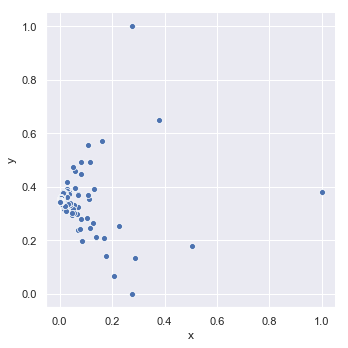

In [29]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="darkgrid")

tdf = pd.read_csv('../features/lcm_merchant_features.csv')
tdf = tdf.drop(['Merchant_id'], axis=1)

ipipe = Pipeline([
    ('pca', PCA(n_components=2)),
    ('scale', MinMaxScaler()),
])

ipipe.fit(tdf)
output = ipipe.transform(tdf)
output_df = pd.DataFrame(data=output, columns=['x', 'y'])

sns.relplot(x="x", y="y", data=output_df);